In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import logging
import datetime
import warnings
import re
import sys 
from copy import deepcopy
from lmfit.models import GaussianModel, LorentzianModel

# from matplotlib.colors import Normalize
from scipy.optimize import curve_fit

plt.rcParams['xtick.major.width'] = 1.8
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['errorbar.capsize'] = 5
plt.rcParams['lines.markersize'] = 4.

In [536]:
def read_tint_power(name):
    powpattern = r'avg100_p(\d+)(uW|nW)_'
    pattern = r'tint_(\d+)(ms|us)'

    match = re.search(pattern, name)
    if match:
        value = int(match.group(1))  # Extract the numeric value of the integration time
        unit = match.group(2)       # Extract the unit (ms or us)
        unitTransf = 1 if unit == 'ms' else 1e-3
        timeInt = value * unitTransf

    matchpower = re.search(powpattern, name)
    if matchpower:
        numpower = int(matchpower.group(1))   # Extract the numeric value of the measured power
        unit_power = matchpower.group(2)        # Extract the unit (uW or nW)
        unitTransf = 1 if unit_power == 'uW' else 1e-3
        power = numpower * unitTransf
    return timeInt, power

def read_spectrum(path, ):
    df = pd.read_csv(path, skiprows=53, sep=';', names=['wv', 'counts'])
    df = df.dropna()
    df['wv'] = df['wv'].astype('float64')
    df.set_index('wv', inplace=True)
    return df

def fit_lorentz(dfsub, pow=None, col=None, flag_plot=True, flag_norm=False, ax=None):
    lor = LorentzianModel()
    x = dfsub.index.values
    y = dfsub.counts.values

    params = lor.guess(y, x=x)
    result = lor.fit(y, params, x=x)
    if flag_plot:
        if ax == None: ax = plt.gca()
        ax.plot(dfsub, 'o-', color=col)
        ax.plot(x, result.best_fit, 'g-', )
        ax.set_title(f'P = {pow} µW')
        lb = 'counts / ms'
        if flag_norm: lb += ' / µW'
        ax.set( xlabel='λ (nm)', ylabel=lb)

    return result

def arrange_results(fits, pows):
    resdf = pd.DataFrame(columns=['laser', 'center', 'error_center', 'fwhm', 'error_fwhm', 'height', 'error_height', 'chisqr', 'rscore'])
    name_cols = ['height', 'fwhm', 'center']
    for p in pows:
        for par in name_cols:
            resdf.loc[p, par] = fits[p].params[par].value
            resdf.loc[p, 'error_'+par] = fits[p].params[par].stderr

        resdf.loc[p, 'chisqr'] = fits[p].chisqr
        resdf.loc[p, 'rscore'] = fits[p].rsquared
        resdf.loc[p, 'laser'] = 'diode'
    return resdf

def plot_results(resdf, col='b'):
    cols = ['center', 'fwhm', 'height']
    lb = ['Center (nm)', 'FWHM (nm)', 'Height (counts/ms)']
    fig, ax = plt.subplots(2,2, figsize=(6,6))

    for i,c in enumerate(cols):
        j, k = i//2, i%2
        ax[j][k].errorbar(resdf[c], resdf.index, xerr=resdf['error_'+c], fmt='o', color=col)
        ax[j][k].set(xlabel=lb[i], ylabel='Power (µW)', yscale='log')

    ax[1][1].plot(resdf['chisqr'].values, resdf.index.values, 'o', color=col)
    ax[1][1].set(xlabel='χ2', ylabel='Power (µW)', yscale='log')
    fig.tight_layout()
    return ax

# Analysis laser spectra: normalized by integration time and power

## Diode laser

In [463]:
rootpath = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/spectrometer_data/laser_spectra/16-01-2025/'
pathdiode = rootpath+'average_diode/*csv'
files = glob.glob(pathdiode)

dfsn = {}
pows = []
for i, name in enumerate(files):
    timeInt, power = read_tint_power(name)
    pows.append(power)
    
    df = read_spectrum(name)
    df['counts'] = df['counts'] / timeInt / power
    dfsub = df[(df.index > 510) & (df.index < 530)]    # Crop x-range
    dfsn[power] = dfsub
pows.sort()

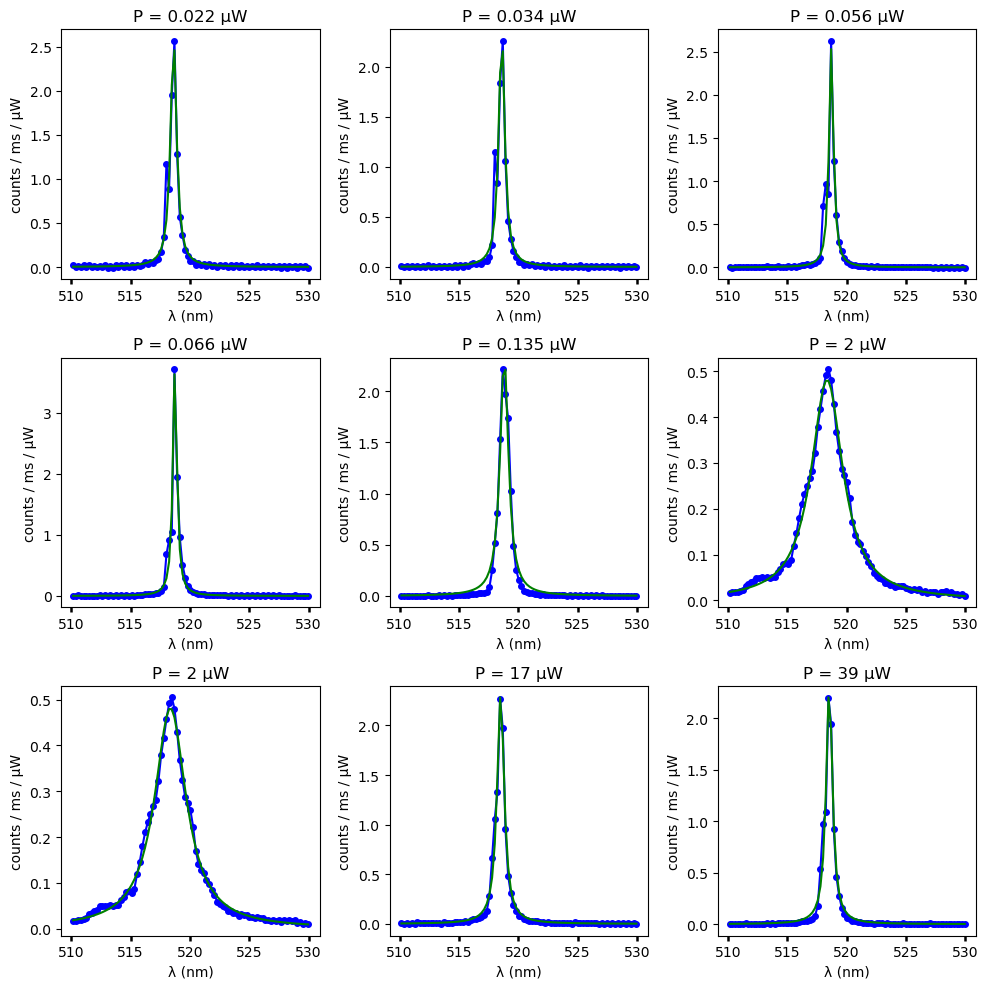

In [464]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
fitsn = {}
for i, pow in enumerate(pows):
    j, k = i%3, i//3
    result = fit_lorentz(dfsn[pow], pow=pow, col='b', flag_plot=True, flag_norm=True, ax=ax[k, j])
    fitsn[pow] = result
fig.tight_layout()

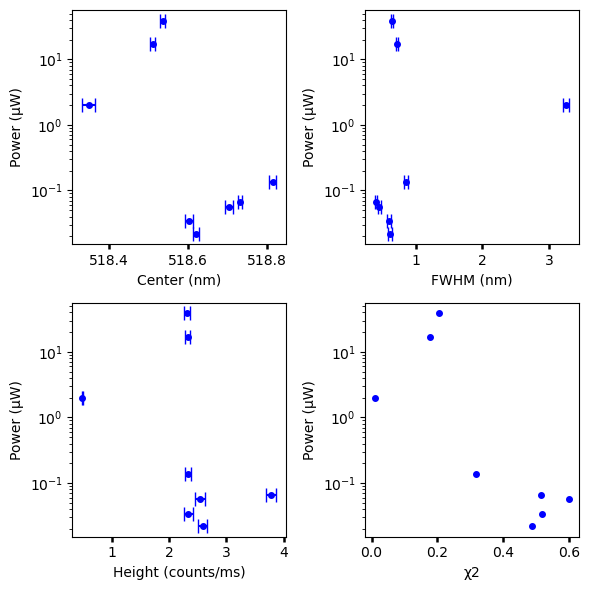

In [524]:
resdioden = arrange_results(fitsn, pows)
plot_results(resdioden);

## TOptica laser

In [413]:
rootpath = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/spectrometer_data/laser_spectra/16-01-2025/'
pathtopt = rootpath+'average_toptica/*csv'
filesop = glob.glob(pathtopt)

dfsopn = {}
powsop = []
for i, name in enumerate(filesop):
    timeInt, power = read_tint_power(name)
    powsop.append(power)
    
    df = read_spectrum(name)
    df['counts'] = df['counts'] / timeInt / power
    dfsub = df[(df.index > 510) & (df.index < 530)]
    dfsopn[power] = dfsub

powsop.sort()

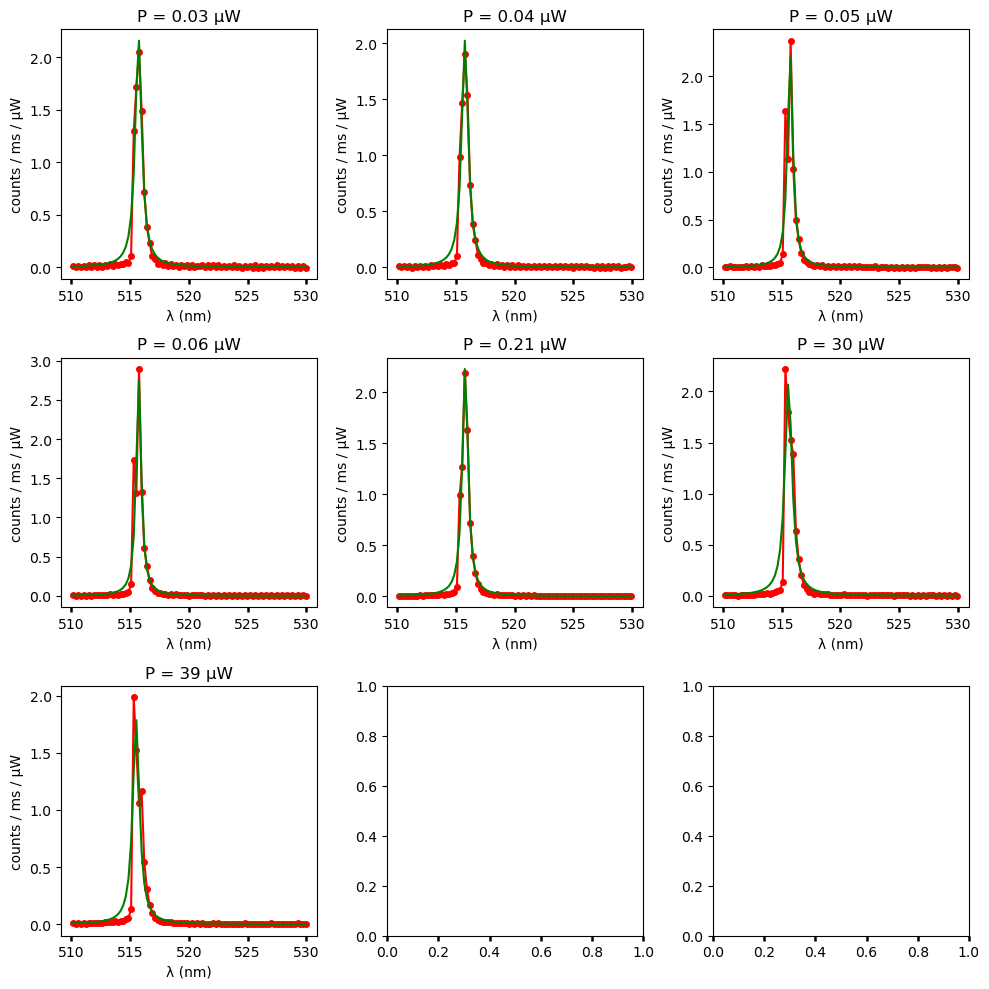

In [414]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
fitsopn = {}

for i, pow in enumerate(powsop):
    j, k = i%3, i//3
    result = fit_lorentz(dfsopn[pow], pow=pow, col='r', flag_plot=True, flag_norm=True, ax=ax[k, j])
    fitsopn[pow] = result
fig.tight_layout()

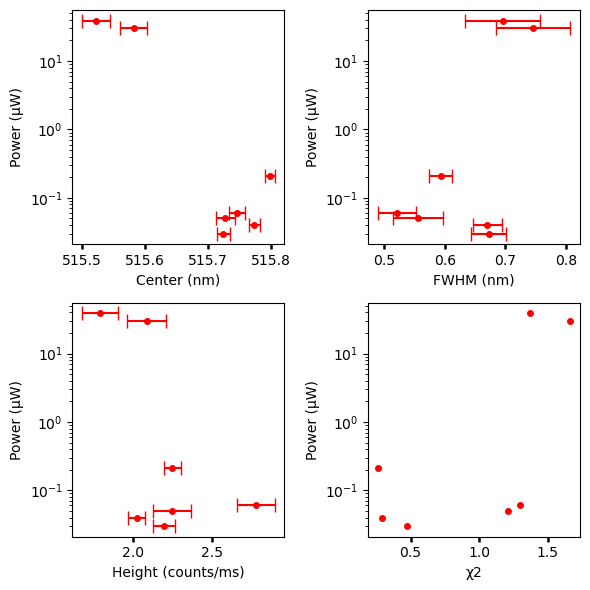

In [ ]:
restopn = arrange_results(fitsopn, powsop)
plot_results(restopn, col='r');

## Compare same power profiles

[Text(0, 0.5, 'counts / ms / µW'),
 Text(0.5, 0, 'λ (nm)'),
 Text(0.5, 1.0, 'P = 0.05 µW')]

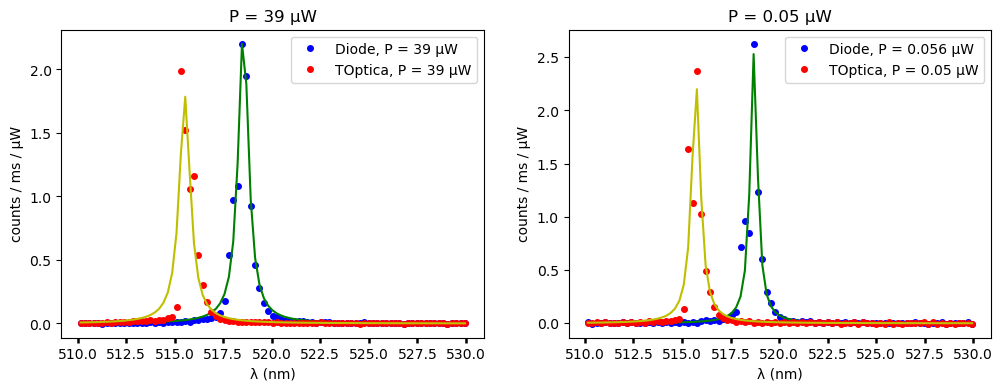

In [372]:
pow = 39
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(dfsn[pow], 'o', color='b', label=f'Diode, P = {pow} µW')
ax[0].plot(dfsn[pow].index.values, fitsn[pow].best_fit, 'g-', )
ax[0].plot(dfsopn[pow], 'o', color='r', label=f'TOptica, P = {pow} µW')
ax[0].plot(dfsopn[pow].index.values, fitsopn[pow].best_fit, 'y-', )
ax[0].legend()
ax[0].set(title=f'P = {pow} µW', xlabel='λ (nm)', ylabel='counts / ms / µW')

pow = 0.056
ax[1].plot(dfsn[pow], 'o', color='b', label=f'Diode, P = {pow} µW')
ax[1].plot(dfsn[pow].index.values, fits[pow].best_fit, 'g-', )

pow = 0.05
ax[1].plot(dfsopn[pow], 'o', color='r', label=f'TOptica, P = {pow} µW')
ax[1].plot(dfsopn[pow].index.values, fitsopn[pow].best_fit, 'y-', )
ax[1].legend()
ax[1].set(title=f'P = {pow} µW', xlabel='λ (nm)', ylabel='counts / ms / µW')

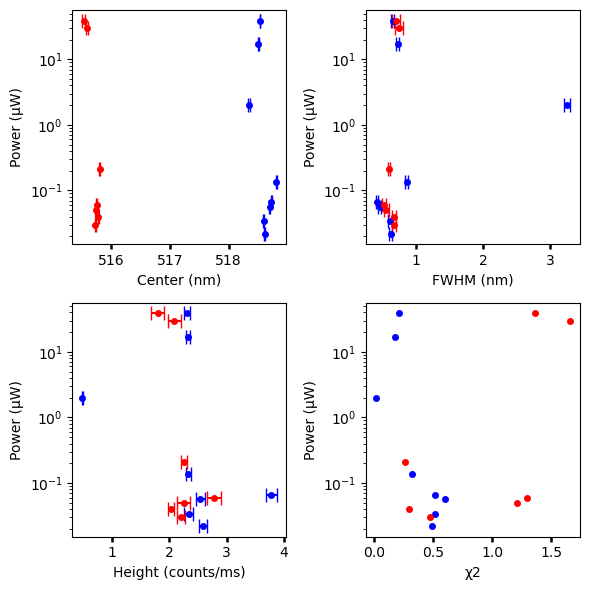

In [526]:
cols = ['center', 'fwhm', 'height']
lb = ['Center (nm)', 'FWHM (nm)', 'Height (counts/ms)']
fig, ax = plt.subplots(2,2, figsize=(6,6))

for i,c in enumerate(cols):
    j, k = i//2, i%2
    ax[j][k].errorbar(resdioden[c], resdioden.index, xerr=resdioden['error_'+c], fmt='o', color='b')
    ax[j][k].errorbar(restopn[c], restopn.index, xerr=restopn['error_'+c], fmt='o', color='r')
    ax[j][k].set(xlabel=lb[i], ylabel='Power (µW)', yscale='log')

ax[1][1].plot(resdioden['chisqr'].values, resdioden.index.values, 'o', color='b')
ax[1][1].plot(restopn['chisqr'].values, restopn.index.values, 'o', color='r')
ax[1][1].set(xlabel='χ2', ylabel='Power (µW)', yscale='log')
fig.tight_layout()

## Summary Statistics

In [537]:
cols2 = ['center', 'fwhm', 'height', 'chisqr', 'rscore']

resdioden[cols2].astype('float32').describe()

,center,fwhm,height,chisqr,rscore
count,8.000000,8.000000,8.000000,8.000000,8.000000
mean,518.608459,0.946299,2.334513,0.354428,0.971472
std,0.146243,0.941605,0.896493,0.208186,0.017342
min,518.347595,0.410830,0.481732,0.011079,0.941643
25%,518.530029,0.568932,2.317446,0.198800,0.961220
50%,518.611206,0.632774,2.331814,0.403714,0.976462
75%,518.710693,0.757022,2.549561,0.515179,0.982655
max,518.814636,3.250492,3.779696,0.600970,0.992868


In [538]:
restopn[cols2].astype('float32').describe()

,center,fwhm,height,chisqr,rscore
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,515.696472,0.636292,2.196401,0.936765,0.913470
std,0.103514,0.081302,0.301538,0.577888,0.054044
min,515.522156,0.520840,1.792431,0.261595,0.839630
25%,515.653198,0.574532,2.055888,0.381186,0.872669
50%,515.727783,0.670167,2.197723,1.210969,0.910440
75%,515.760193,0.683877,2.248681,1.329747,0.962487
max,515.798889,0.746218,2.775513,1.662921,0.973907


# Analysis unnormalized by power

## Diode laser

In [376]:
rootpath = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/spectrometer_data/laser_spectra/16-01-2025/'
pathdiode = rootpath+'average_diode/*csv'
files = glob.glob(pathdiode)

dfs = {}
pows = []
for i, name in enumerate(files):
    timeInt, power = read_tint_power(name)
    pows.append(power)
    
    df = read_spectrum(name)
    df['counts'] = df['counts'] / timeInt
    dfsub = df[(df.index > 510) & (df.index < 530)]
    dfs[power] = dfsub
pows.sort()
fig.tight_layout()

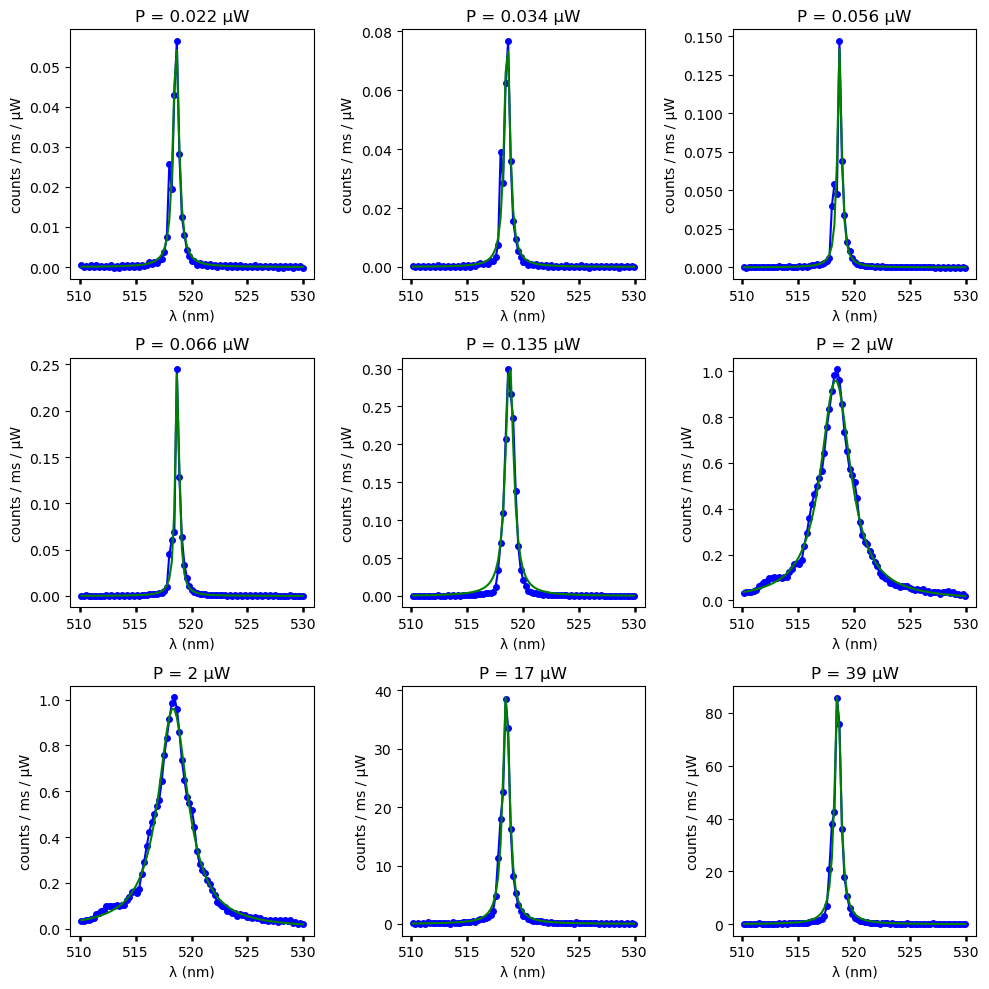

In [377]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
fits = {}

for i, pow in enumerate(pows):
    j, k = i%3, i//3
    result = fit_lorentz(dfs[pow], pow=pow, col='b', flag_plot=True, flag_norm=True, ax=ax[k, j])
    fits[pow] = result
fig.tight_layout()

[None, (5e-05, 100.0)]

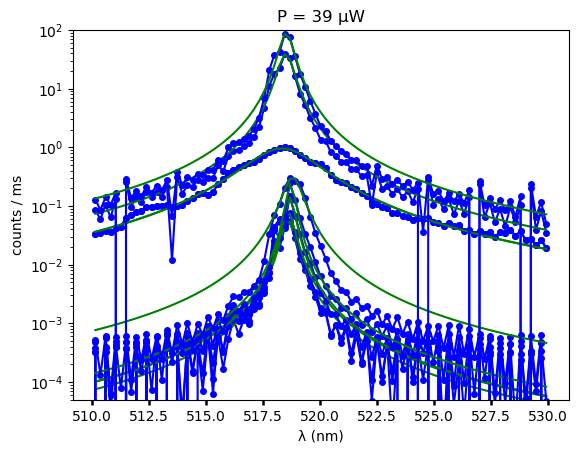

In [552]:
for pow in pows:
    fit_lorentz(dfs[pow], pow=pow, col='b')
plt.gca().set(yscale='log', ylim=(5e-5, 1e2))


[None]

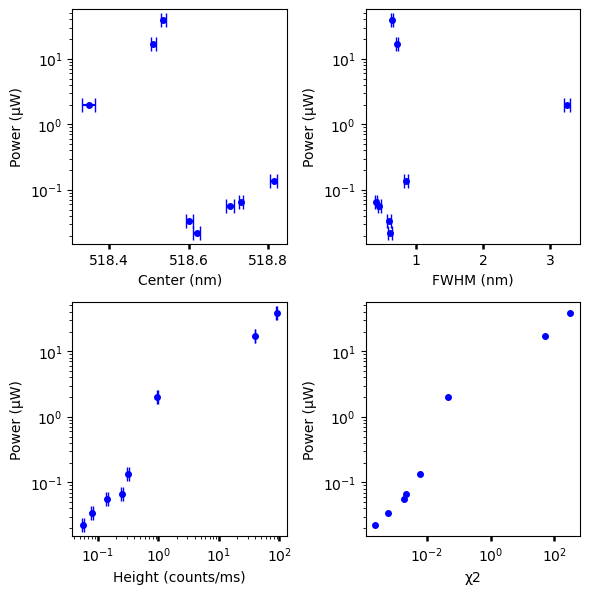

In [ ]:
resdiode = arrange_results(fits, pows)
ax = plot_results(resdiode, col='b')
ax[1][0].set(xscale='log')
ax[1][1].set(xscale='log')

## TOptica

In [380]:
rootpath = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/spectrometer_data/laser_spectra/16-01-2025/'
pathtopt = rootpath+'average_toptica/*csv'
filesop = glob.glob(pathtopt)

dfsop = {}
powsop = []
for i, name in enumerate(filesop):
    timeInt, power = read_tint_power(name)
    powsop.append(power)
    
    df = read_spectrum(name)
    df['counts'] = df['counts'] / timeInt
    dfsub = df[(df.index > 510) & (df.index < 530)]
    dfsop[power] = dfsub

powsop.sort()
fig.tight_layout()

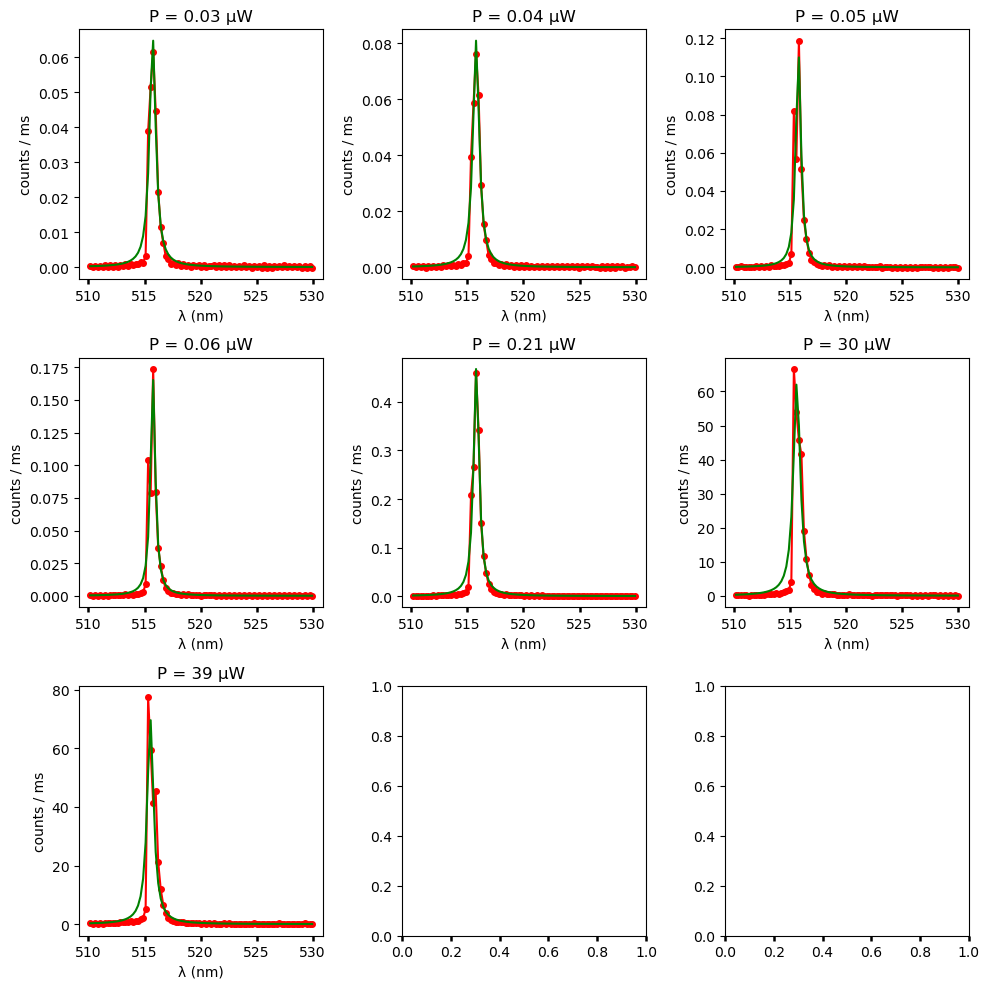

In [381]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
fitsop = {}

for i, pow in enumerate(powsop):
    j, k = i%3, i//3
    result = fit_lorentz(dfsop[pow], pow=pow, col='r', flag_plot=True, flag_norm=False, ax=ax[k, j])
    fitsop[pow] = result
fig.tight_layout()

[None, (5e-05, 100.0)]

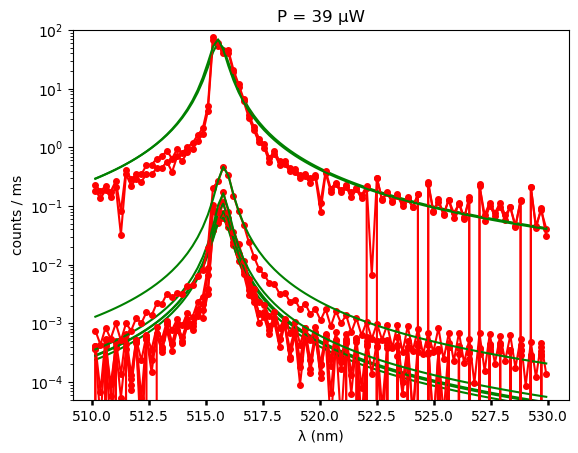

In [382]:
for pow in powsop:
    fit_lorentz(dfsop[pow], pow=pow, col='r')
plt.gca().set(yscale='log', ylim=(5e-5, 1e2))

[None]

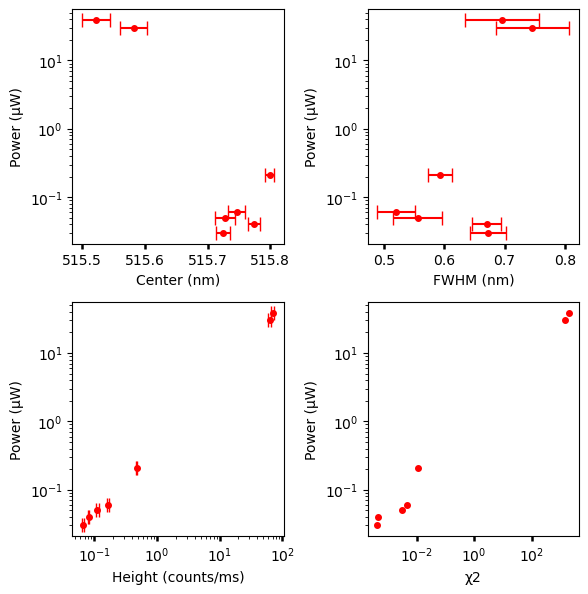

In [542]:
restop = arrange_results(fitsop, powsop)
ax = plot_results(restop, col='r')
ax[1][0].set(xscale='log')
ax[1][1].set(xscale='log')

## Compare same power profiles

[Text(0, 0.5, 'counts / ms / µW'),
 Text(0.5, 0, 'λ (nm)'),
 Text(0.5, 1.0, 'P = 0.05 µW')]

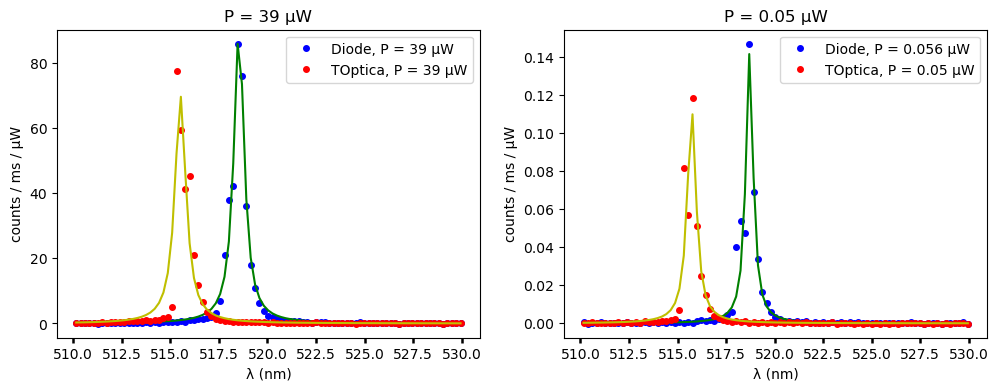

In [384]:
pow = 39
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(dfs[pow], 'o', color='b', label=f'Diode, P = {pow} µW')
ax[0].plot(dfs[pow].index.values, fits[pow].best_fit, 'g-', )
ax[0].plot(dfsop[pow], 'o', color='r', label=f'TOptica, P = {pow} µW')
ax[0].plot(dfsop[pow].index.values, fitsop[pow].best_fit, 'y-', )
ax[0].legend()
ax[0].set(title=f'P = {pow} µW', xlabel='λ (nm)', ylabel='counts / ms / µW')

pow = 0.056
ax[1].plot(dfs[pow], 'o', color='b', label=f'Diode, P = {pow} µW')
ax[1].plot(dfs[pow].index.values, fits[pow].best_fit, 'g-', )

pow = 0.05
ax[1].plot(dfsop[pow], 'o', color='r', label=f'TOptica, P = {pow} µW')
ax[1].plot(dfsop[pow].index.values, fitsop[pow].best_fit, 'y-', )
ax[1].legend()
ax[1].set(title=f'P = {pow} µW', xlabel='λ (nm)', ylabel='counts / ms / µW')

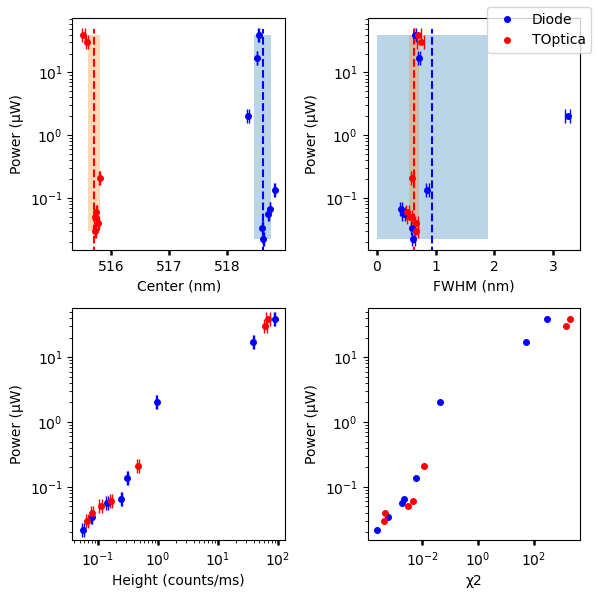

In [ ]:
cols = ['center', 'fwhm', 'height']
lb = ['Center (nm)', 'FWHM (nm)', 'Height (counts/ms)']
fig, ax = plt.subplots(2,2, figsize=(6,6))

for i,c in enumerate(cols):
    j, k = i//2, i%2
    ax[j][k].errorbar(resdiode[c], resdiode.index, xerr=resdiode['error_'+c], fmt='o', color='b')
    ax[j][k].errorbar(restop[c], restop.index, xerr=restop['error_'+c], fmt='o', color='r')
    ax[j][k].set(xlabel=lb[i], ylabel='Power (µW)', yscale='log')
    if i < 2:
        ax[j][k].vlines(resdiode[c].mean(), 0, 50, color='b', ls='--')
        ax[j][k].vlines(restop[c].mean(), 0, 50, color='r', ls='--')
        ax[j][k].fill_betweenx(resdiode.index, resdiode[c].mean() - resdiode[c].std(), resdiode[c].mean() + resdiode[c].std(), alpha=0.3)
        ax[j][k].fill_betweenx(restop.index, restop[c].mean() - restop[c].std(), restop[c].mean() + restop[c].std(), alpha=0.3)

ax[1][0].set(xscale='log')
curve_fit()

ax[1][1].plot(resdiode['chisqr'].values, resdiode.index.values, 'o', color='b', label='Diode')
ax[1][1].plot(restop['chisqr'].values, restop.index.values, 'o', color='r', label='TOptica')
ax[1][1].set(xlabel='χ2', ylabel='Power (µW)', yscale='log', xscale='log')
fig.legend()
fig.tight_layout()


In [566]:
c = 'center'
resdiode[c].mean() - resdiode[c].std(), resdiode[c].mean() + resdiode[c].std()

518.4622195963103

In [568]:
resdiode[c].astype('float32').describe()

count      8.000000
mean     518.608459
std        0.146243
min      518.347595
25%      518.530029
50%      518.611206
75%      518.710693
max      518.814636
Name: center, dtype: float64

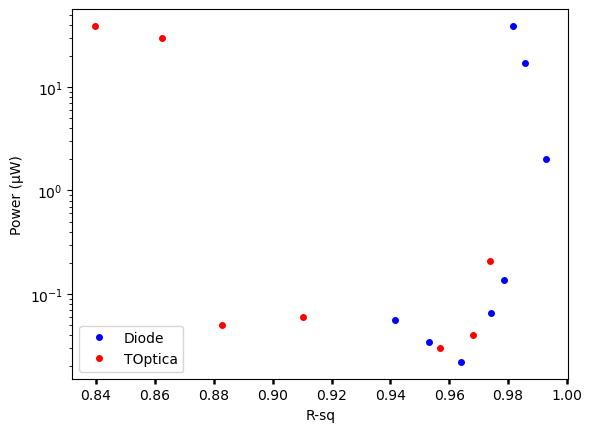

In [550]:
plt.plot(resdiode['rscore'].values, resdiode.index.values, 'o', color='b', label='Diode')
plt.plot(restop['rscore'].values, restop.index.values, 'o', color='r', label='TOptica')
plt.gca().set(xlabel='R-sq', ylabel='Power (µW)', yscale='log')
plt.legend()